#Problem Statement :
###Forecast state-item level sales for next 90 days: 23-02-2022 to 23-05-2022.
#Data Description:
###Data contains daily state-item level sales of a pharmaceutical company across 3 different states – MH, TN and UP. The data is from 29-01-2017 to 22-02-2022.
##Submission by Tuhin Roychowdhury (A9109119820003) - Amity University Kolkata - Btech AI



#This notebook will be divided into the following sections.
1) Data Cleaning or Preprocessing
2) Feature Engineering
3) Exploratory Data Analysis
4) Model Training
5) Model Evaluation
6) Chart Discussion

#Data Cleaning and Preprocessing

##Importing Libraries

In [6]:
import os
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

import itertools
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import array

In [7]:
!pip install plotly


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


##Dataset loading

In [8]:
file_path = r'C:\Users\rctuh\Desktop\mankind\dataset\TRAIN.csv'

In [9]:
df = pd.read_csv(file_path)

In [10]:
df.head()

,Item code,Category,State,29-01-2017,30-01-2017,31-01-2017,01-02-2017,02-02-2017,03-02-2017,04-02-2017,...,13-02-2022,14-02-2022,15-02-2022,16-02-2022,17-02-2022,18-02-2022,19-02-2022,20-02-2022,21-02-2022,22-02-2022
0,ANTIDIABETIC_001,ANTIDIABETIC,MH,0,0,0,0,0,0,0,...,4,0,0,0,0,1,1,2,0,4
1,ANTIDIABETIC_002,ANTIDIABETIC,MH,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,ANTIDIABETIC_003,ANTIDIABETIC,MH,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
3,ANTIDIABETIC_004,ANTIDIABETIC,MH,0,0,0,0,0,0,0,...,2,1,0,0,0,2,0,5,4,2
4,ANTIDIABETIC_005,ANTIDIABETIC,MH,0,0,0,0,0,0,0,...,5,2,2,2,1,0,0,0,3,0


In [11]:
df.columns

Index(['Item code', 'Category', 'State', '29-01-2017', '30-01-2017',
       '31-01-2017', '01-02-2017', '02-02-2017', '03-02-2017', '04-02-2017',
       ...
       '13-02-2022', '14-02-2022', '15-02-2022', '16-02-2022', '17-02-2022',
       '18-02-2022', '19-02-2022', '20-02-2022', '21-02-2022', '22-02-2022'],
      dtype='object', length=1854)

###Converting the dataset to "Long Format" for ease and better data readability

In [12]:
# Convert the wide dataframe to long format
df_long = pd.melt(df, id_vars=['Item code', 'Category', 'State'], var_name='Date', value_name='Sales')

# Convert the 'Date' column to datetime format
df_long['Date'] = pd.to_datetime(df_long['Date'], dayfirst=True)

# Sort the dataframe by 'Date' (
df_long.sort_values(by=['Date'], inplace=True)

# Reset index after sorting
df_long.reset_index(drop=True, inplace=True)

# Display the first few rows of the transformed dataframe
print(df_long.head())

          Item code      Category State       Date  Sales
0  ANTIDIABETIC_001  ANTIDIABETIC    MH 2017-01-29      0
1    ANTIBIOTIC_213    ANTIBIOTIC    UP 2017-01-29      1
2    ANTIBIOTIC_214    ANTIBIOTIC    UP 2017-01-29      0
3    ANTIBIOTIC_215    ANTIBIOTIC    UP 2017-01-29      0
4    ANTIBIOTIC_216    ANTIBIOTIC    UP 2017-01-29      0


In [13]:
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Create 'Year', 'Month', 'Day', and 'Weekday' columns
df_long['Year'] = df_long['Date'].dt.year
df_long['Month'] = df_long['Date'].dt.month
df_long['Day'] = df_long['Date'].dt.day
df_long['Weekday'] = df_long['Date'].dt.weekday  # Monday=0, Sunday=6

# Check the first few rows to confirm the new columns are correctly created
print(df_long.head())


          Item code      Category State       Date  Sales  Year  Month  Day  \
0  ANTIDIABETIC_001  ANTIDIABETIC    MH 2017-01-29      0  2017      1   29   
1    ANTIBIOTIC_213    ANTIBIOTIC    UP 2017-01-29      1  2017      1   29   
2    ANTIBIOTIC_214    ANTIBIOTIC    UP 2017-01-29      0  2017      1   29   
3    ANTIBIOTIC_215    ANTIBIOTIC    UP 2017-01-29      0  2017      1   29   
4    ANTIBIOTIC_216    ANTIBIOTIC    UP 2017-01-29      0  2017      1   29   

   Weekday  
0        6  
1        6  
2        6  
3        6  
4        6  


#Initial Data Cleaning

In [14]:
# Check for missing values
print("Missing values per column:")
print(df_long.isnull().sum())

Missing values per column:
Item code    0
Category     0
State        0
Date         0
Sales        0
Year         0
Month        0
Day          0
Weekday      0
dtype: int64


In [15]:
# Check for duplicates (considering all relevant columns)
print("Duplicate rows:", df_long.duplicated(subset=['Item code', 'Category', 'State', 'Date']).sum())

# Remove duplicates (if any)
df_long.drop_duplicates(subset=['Item code', 'Category', 'State', 'Date'], inplace=True)

Duplicate rows: 0


#Exploratory Data Analysis - EDA

In [16]:
!pip install plotly
import plotly.express as px



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


##Overall Sales Trends

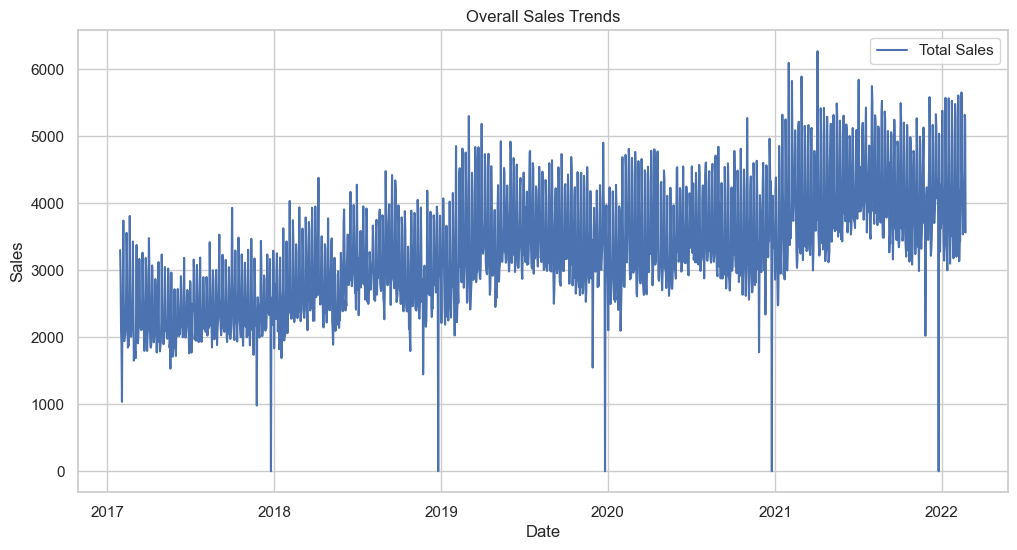

In [17]:
# Setting seaborn style for plots
sns.set(style="whitegrid")

# Aggregate sales by date to see overall trends
overall_sales_trends = df_long.groupby('Date')['Sales'].sum().reset_index()

# Plotting overall sales trends
plt.figure(figsize=(12, 6))
plt.plot(overall_sales_trends['Date'], overall_sales_trends['Sales'], label='Total Sales')
plt.title('Overall Sales Trends')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [18]:
fig = px.line(overall_sales_trends, x='Date', y='Sales', title='Overall Sales Trends', labels={'Sales': 'Total Sales'})
fig.update_xaxes(rangeslider_visible=True)
fig.show()


#Seasonality and Trends by State

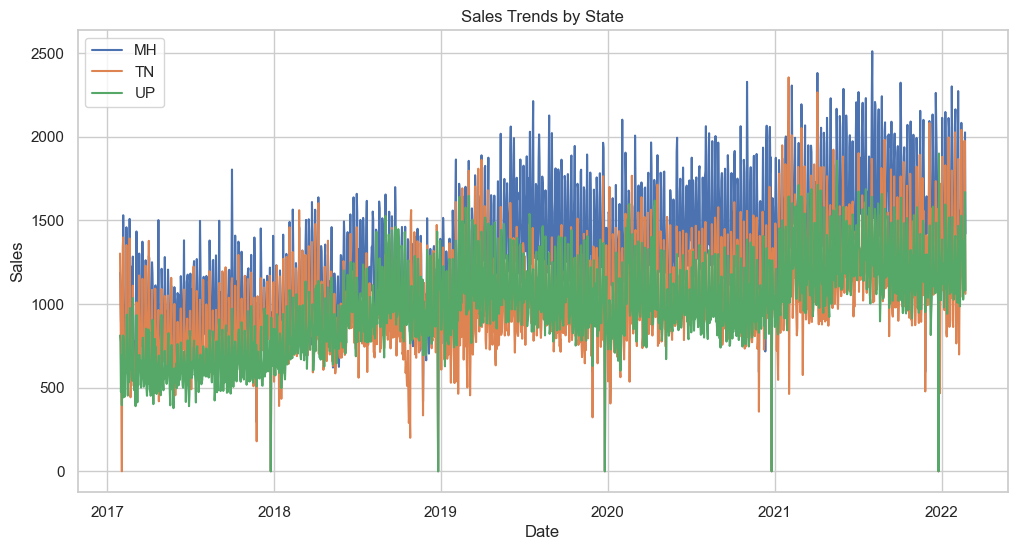

In [19]:
# Aggregate sales by date and state
state_sales_trends = df_long.groupby(['Date', 'State'])['Sales'].sum().reset_index()

# Plotting sales trends by state
plt.figure(figsize=(12, 6))
for state in state_sales_trends['State'].unique():
    plt.plot(state_sales_trends[state_sales_trends['State'] == state]['Date'],
             state_sales_trends[state_sales_trends['State'] == state]['Sales'], label=state)
plt.title('Sales Trends by State')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [20]:
fig = px.line(state_sales_trends, x='Date', y='Sales', color='State', title='Sales Trends by State')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


#Checking for Seasonality

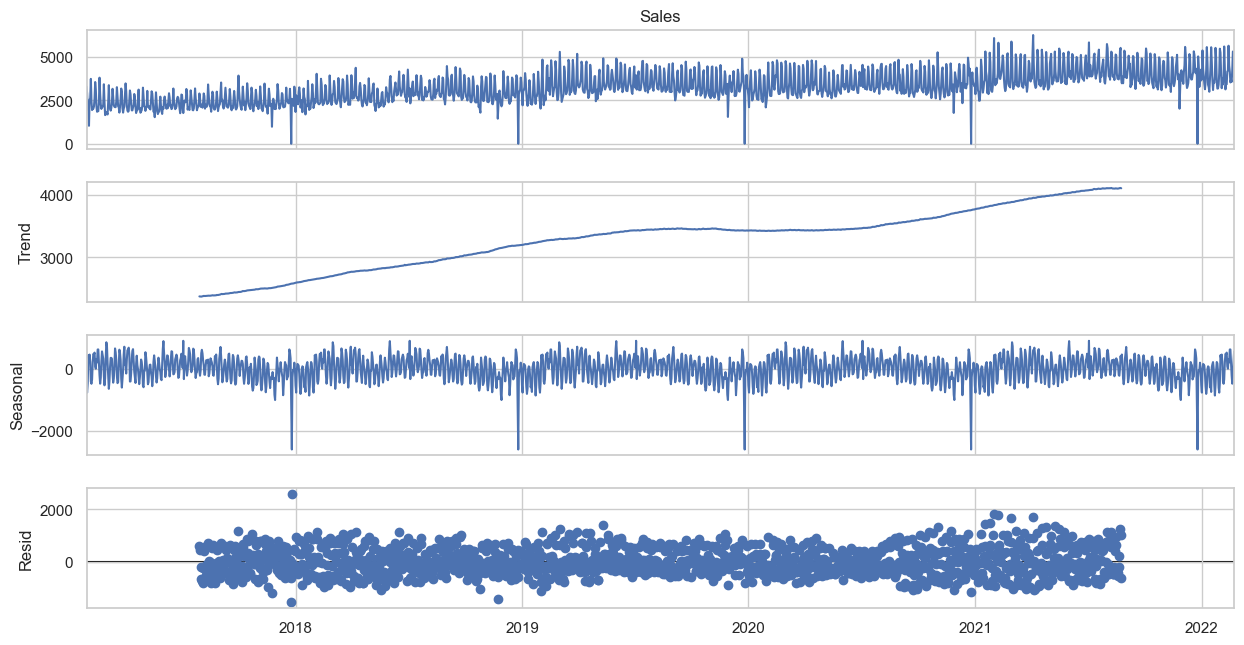

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

#We use a decomposition plot here
decomposition = seasonal_decompose(overall_sales_trends.set_index('Date')['Sales'], model='additive', period=365)
#assuming the period to be yearly

# Plotting the decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()


In [24]:
trend_data = decomposition.trend.reset_index()
fig = px.line(trend_data, x='Date', y='trend', title='Trend Component of Sales')
fig.show()


#Sales Distribution by Category

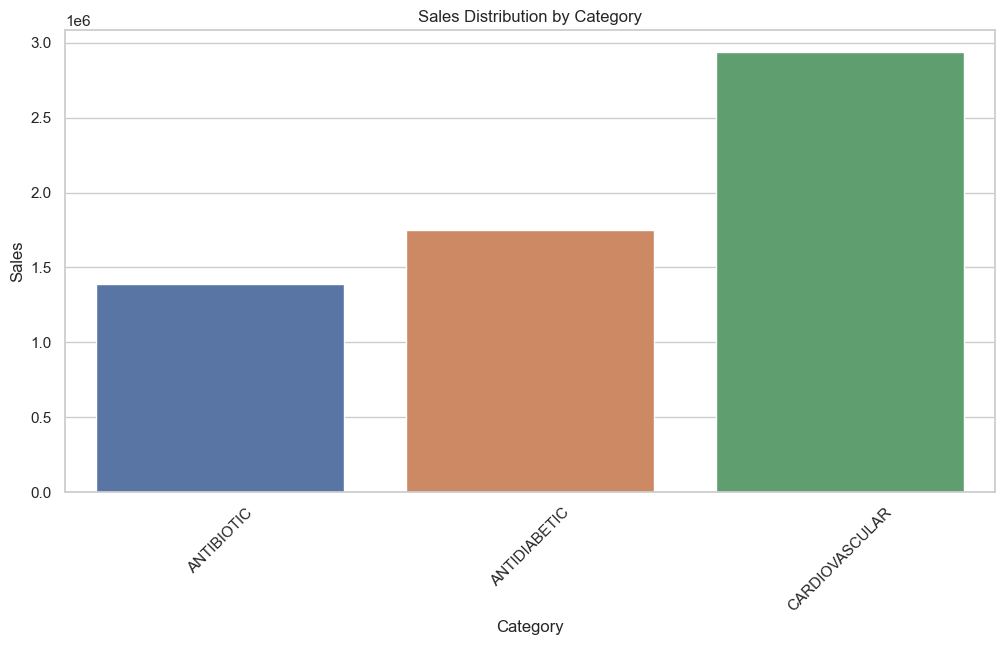

In [25]:
# Aggregate sales by category
category_sales = df_long.groupby('Category')['Sales'].sum().reset_index()

# Plotting sales distribution by category
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Sales', data=category_sales)
plt.title('Sales Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()


In [26]:
fig = px.bar(category_sales, x='Category', y='Sales', title='Sales Distribution by Category')
fig.show()


#Outliers and Anomalies

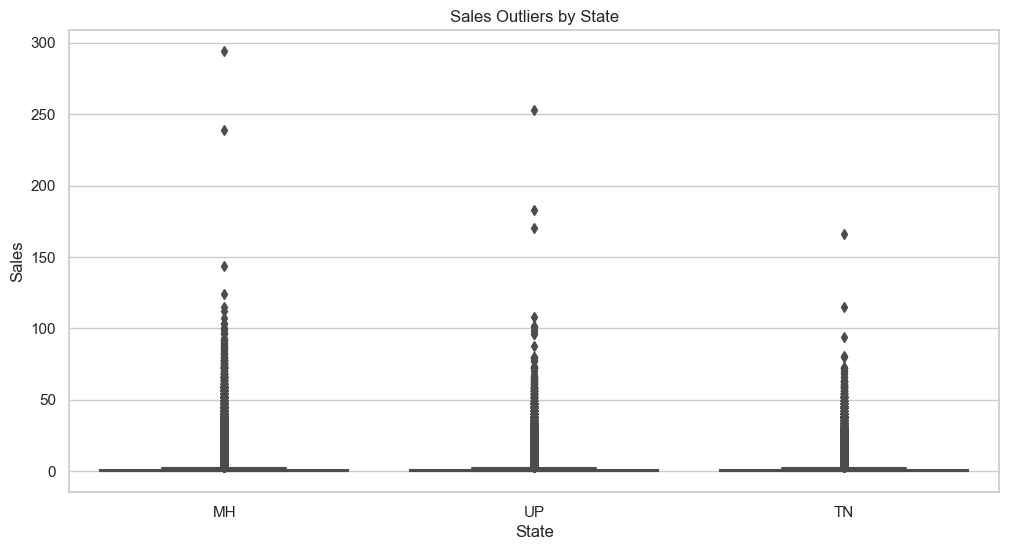

In [27]:
# Boxplot to visualize outliers by state
plt.figure(figsize=(12, 6))
sns.boxplot(x='State', y='Sales', data=df_long)
plt.title('Sales Outliers by State')
plt.xlabel('State')
plt.ylabel('Sales')
plt.show()


#Sales Trends by Weekday and Month

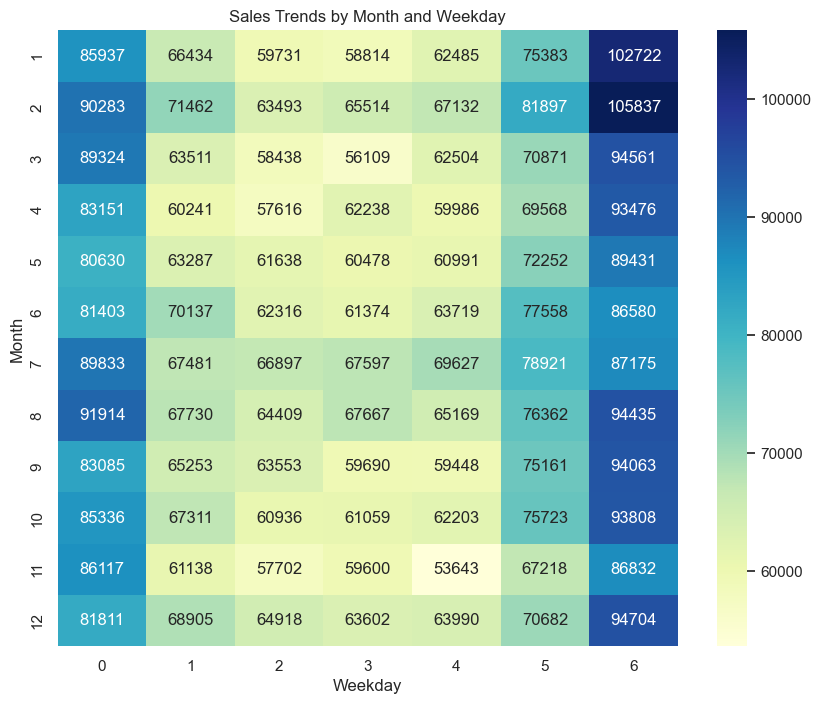

In [28]:
# Creating a pivot table to aggregate sales by Month and Weekday
pivot_table = df_long.pivot_table(values='Sales', index='Month', columns='Weekday', aggfunc=np.sum)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title('Sales Trends by Month and Weekday')
plt.xlabel('Weekday')
plt.ylabel('Month')
plt.show()


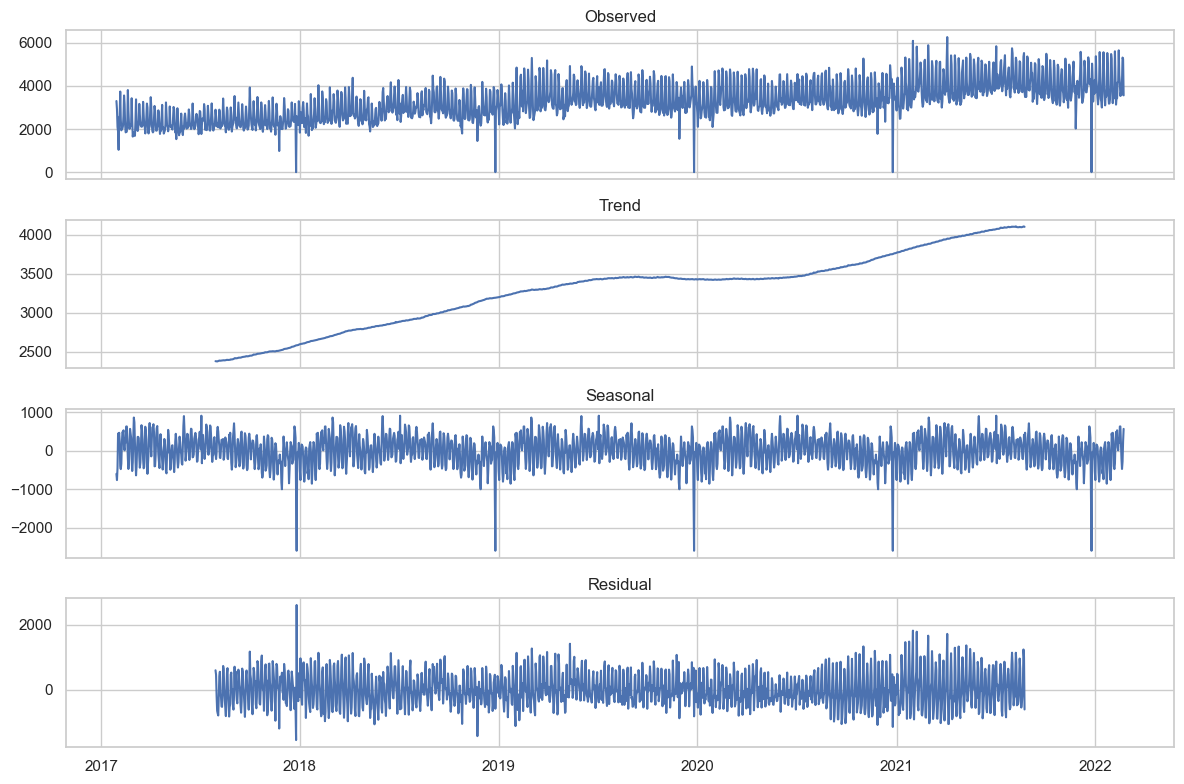

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(overall_sales_trends.set_index('Date')['Sales'], model='additive', period=365)

fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

ax[0].plot(decomposition.observed)
ax[0].set_title('Observed')

ax[1].plot(decomposition.trend)
ax[1].set_title('Trend')

ax[2].plot(decomposition.seasonal)
ax[2].set_title('Seasonal')

ax[3].plot(decomposition.resid)
ax[3].set_title('Residual')

plt.tight_layout()
plt.show()


#Using pair plots for multivariate analysis

C:\Users\rctuh\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



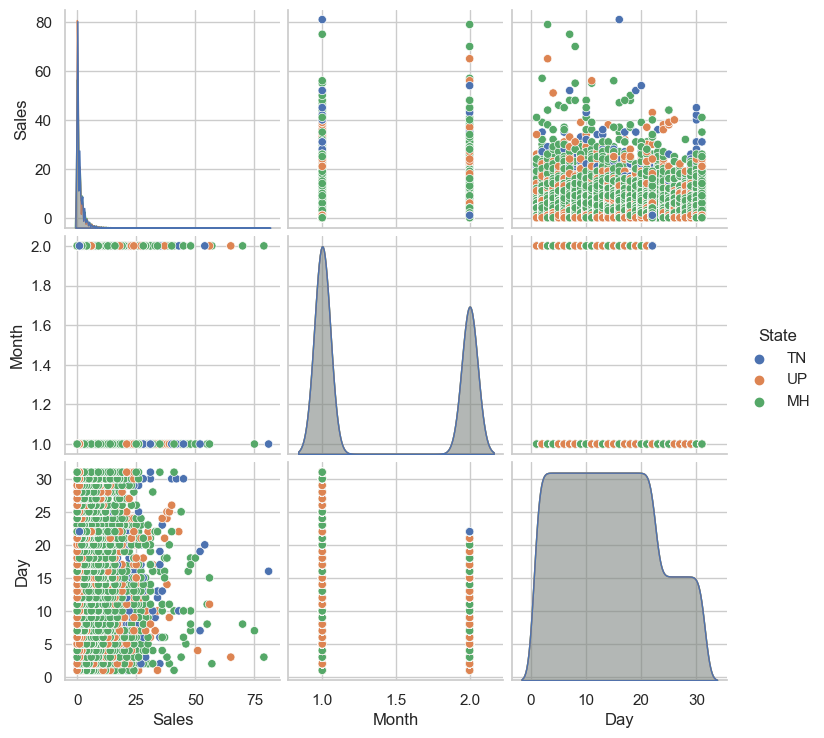

In [30]:
subset_data = df_long[df_long['Year'] == 2022]

sns.pairplot(subset_data, hue='State', vars=['Sales', 'Month', 'Day'])
plt.show()


#Distribution of Sales

C:\Users\rctuh\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



<Figure size 1000x600 with 0 Axes>

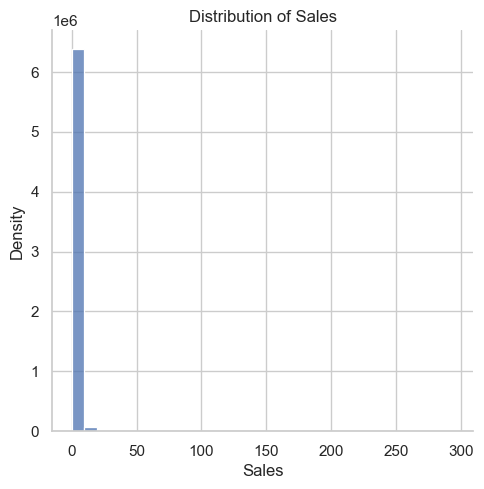

In [31]:
plt.figure(figsize=(10, 6))
sns.displot(df_long['Sales'], bins=30)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Density')
plt.show()


#Autocorrelation Plot

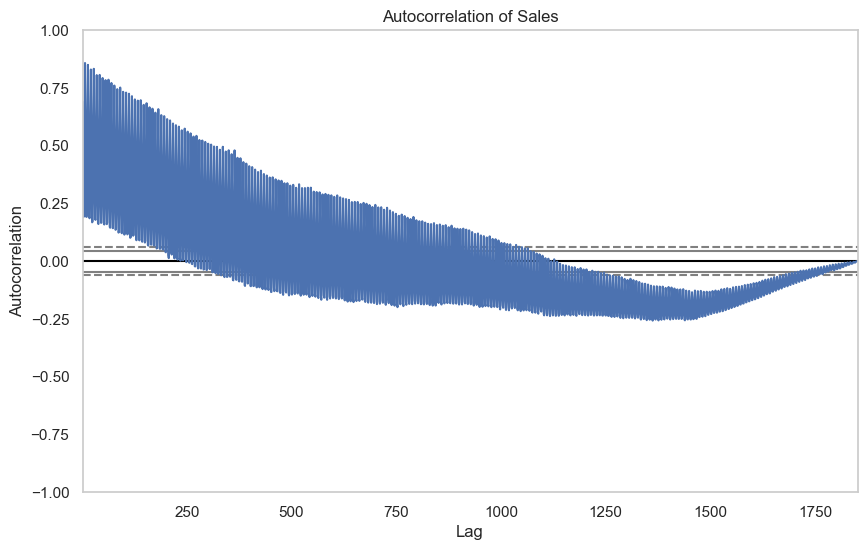

In [32]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(overall_sales_trends['Sales'])
plt.title('Autocorrelation of Sales')
plt.show()


#Analysing the trend for holidays

In [33]:
holiday_dates = {
    'Republic Day': ['2017-01-26', '2018-01-26', '2019-01-26', '2020-01-26', '2021-01-26', '2022-01-26'],
    'Independence Day': ['2017-08-15', '2018-08-15', '2019-08-15', '2020-08-15', '2021-08-15', '2022-08-15'],
    'Gandhi Jayanti': ['2017-10-02', '2018-10-02', '2019-10-02', '2020-10-02', '2021-10-02', '2022-10-02'],

    'Diwali': ['2017-10-19', '2018-11-07', '2019-10-27', '2020-11-14', '2021-11-04']
}


C:\Users\rctuh\AppData\Local\Temp\ipykernel_18108\2244746282.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rctuh\AppData\Local\Temp\ipykernel_18108\2244746282.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rctuh\AppData\Local\Temp\ipykernel_18108\2244746282.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

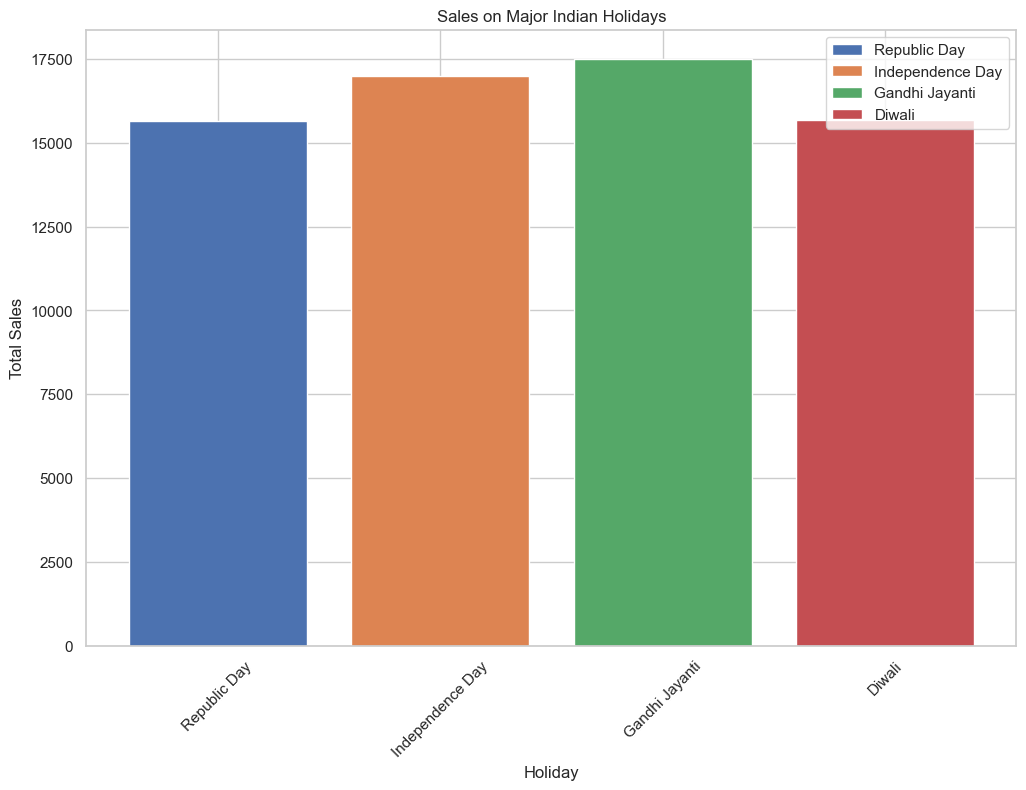

In [34]:
# Convert 'Date' column to datetime if not already
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Initialize a DataFrame to hold holiday sales data
holiday_sales = pd.DataFrame()

for holiday, dates in holiday_dates.items():
    for date in dates:
        # Extract sales data for each holiday
        temp_df = df_long[df_long['Date'] == pd.to_datetime(date)]
        temp_df['Holiday'] = holiday
        holiday_sales = pd.concat([holiday_sales, temp_df])

# Plotting
plt.figure(figsize=(12, 8))
for holiday in holiday_sales['Holiday'].unique():
    # Filter data for each holiday and sum up sales
    temp_df = holiday_sales[holiday_sales['Holiday'] == holiday]
    plt.bar(holiday, temp_df['Sales'].sum(), label=holiday)

plt.title('Sales on Major Indian Holidays')
plt.xlabel('Holiday')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [35]:
df_long.columns

Index(['Item code', 'Category', 'State', 'Date', 'Sales', 'Year', 'Month',
       'Day', 'Weekday'],
      dtype='object')

Top 10 Most Sold Products Plot: Helps in quickly identifying the products that contribute most to sales, guiding inventory and marketing strategies.

Monthly Sales Trend for the Most Sold Product: Provides insights into how the sales of the most popular product fluctuate over time, identifying peak periods for targeted promotions or stock adjustments.

Overall Monthly Sales Plot: Shows the sales trend across all products and states, highlighting peak sales months which can be crucial for planning purposes.

#Calculating the most sold product

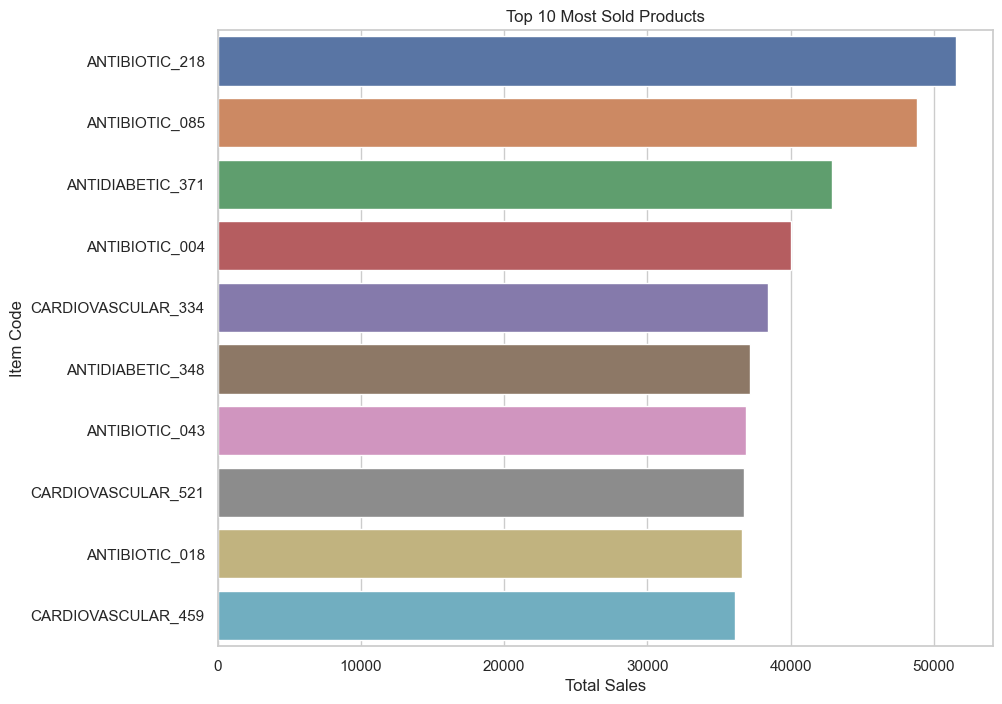

In [36]:
# Aggregate sales by item code
sales_by_product = df_long.groupby('Item code')['Sales'].sum().reset_index()

# Sort products by sales
sales_by_product_sorted = sales_by_product.sort_values('Sales', ascending=False)

# Plotting sales distribution across products
plt.figure(figsize=(10, 8))
sns.barplot(x='Sales', y='Item code', data=sales_by_product_sorted.head(10))  # Displaying top 10 for readability
plt.title('Top 10 Most Sold Products')
plt.xlabel('Total Sales')
plt.ylabel('Item Code')
plt.show()

In [37]:
most_sold_product = df_long.groupby('Item code')['Sales'].sum().idxmax()
most_sold_sales = df_long.groupby('Item code')['Sales'].sum().max()


#Monthly Sales Trend of most sold product

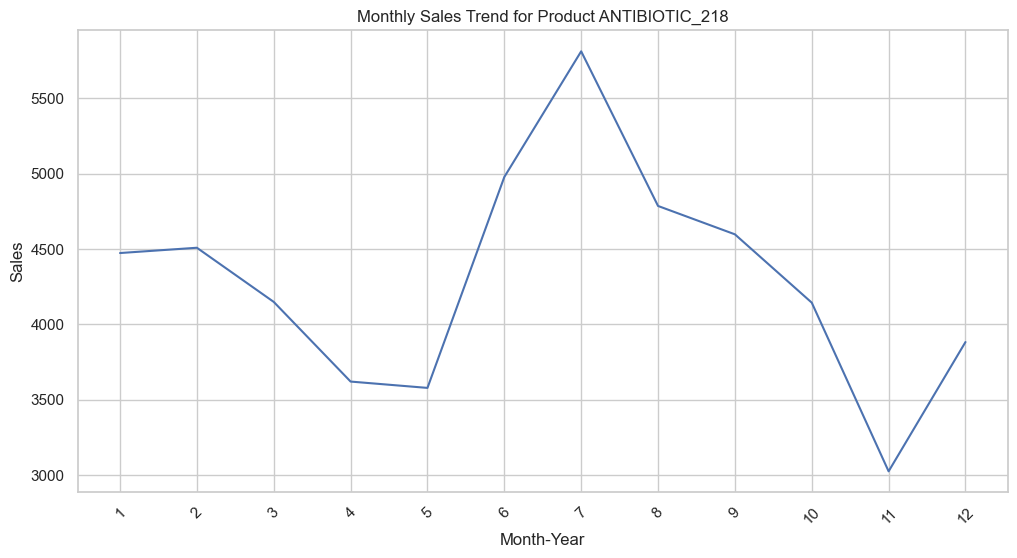

In [38]:
monthly_sales = df_long[df_long['Item code'] == most_sold_product].groupby('Month')['Sales'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(str)  # Convert to string for plotting

plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Sales', data=monthly_sales)
plt.xticks(rotation=45)
plt.title(f'Monthly Sales Trend for Product {most_sold_product}')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.show()


#Overall monthly sales

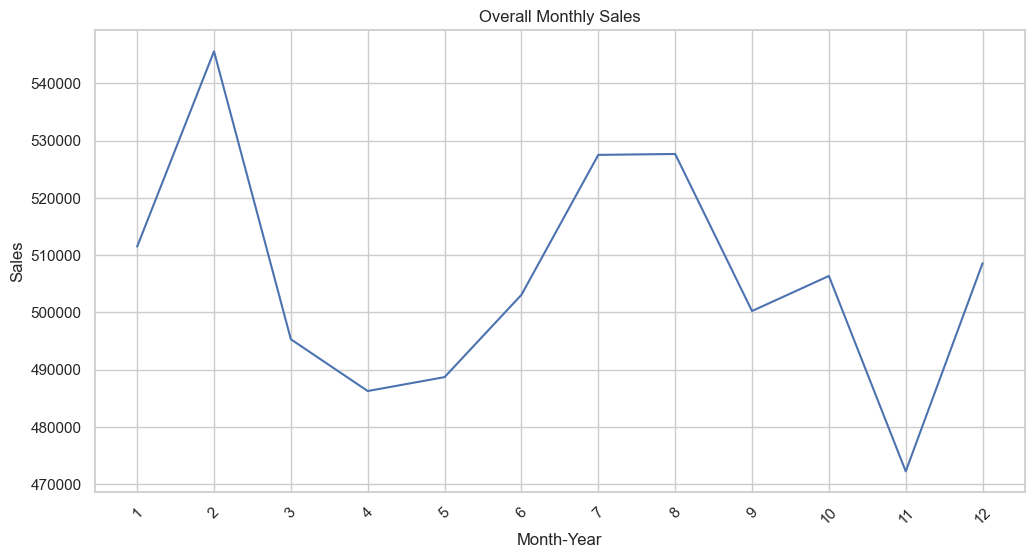

In [39]:
overall_monthly_sales = df_long.groupby('Month')['Sales'].sum().reset_index()
overall_monthly_sales['Month'] = overall_monthly_sales['Month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Sales', data=overall_monthly_sales)
plt.xticks(rotation=45)
plt.title('Overall Monthly Sales')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.show()


#Implementing Feature Engineering

Generating lag since Lag features can help capture the sales momentum and autocorrelation in sales data.

In [40]:
df_long['lag_1'] = df_long.groupby(['Item code'])['Sales'].shift(1)
df_long['lag_7'] = df_long.groupby(['Item code'])['Sales'].shift(7)
df_long['lag_30'] = df_long.groupby(['Item code'])['Sales'].shift(30)


In [41]:
# Check for missing values
print("Missing values per column:")
print(df_long.isnull().sum())

Missing values per column:
Item code        0
Category         0
State            0
Date             0
Sales            0
Year             0
Month            0
Day              0
Weekday          0
lag_1         1164
lag_7         8148
lag_30       34920
dtype: int64


In [42]:
df_long['lag_1']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
6463687    2.0
6463688    0.0
6463689    0.0
6463690    0.0
6463691    2.0
Name: lag_1, Length: 6463692, dtype: float64

#Using Classical Machine learning methods

In [43]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6463692 entries, 0 to 6463691
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Item code  object        
 1   Category   object        
 2   State      object        
 3   Date       datetime64[ns]
 4   Sales      int64         
 5   Year       int32         
 6   Month      int32         
 7   Day        int32         
 8   Weekday    int32         
 9   lag_1      float64       
 10  lag_7      float64       
 11  lag_30     float64       
dtypes: datetime64[ns](1), float64(3), int32(4), int64(1), object(3)
memory usage: 493.1+ MB


#Using Groupwise fill to handle missing or nan values generated by lag

In [44]:
df_long['lag_1'] = df_long.groupby('Item code',group_keys=False)['lag_1'].apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
df_long['lag_7'] = df_long.groupby('Item code',group_keys=False)['lag_7'].apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
df_long['lag_30'] = df_long.groupby('Item code',group_keys=False)['lag_30'].apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))


In [45]:
df_long['lag_1'], df_long['lag_30']

(0          0.0
 1          1.0
 2          0.0
 3          0.0
 4          0.0
           ... 
 6463687    2.0
 6463688    0.0
 6463689    0.0
 6463690    0.0
 6463691    2.0
 Name: lag_1, Length: 6463692, dtype: float64,
 0          0.0
 1          1.0
 2          0.0
 3          0.0
 4          0.0
           ... 
 6463687    0.0
 6463688    2.0
 6463689    1.0
 6463690    1.0
 6463691    5.0
 Name: lag_30, Length: 6463692, dtype: float64)

#Using Rolling window to capture trends and patterns over specific time windows

In [46]:
# 7-day rolling mean
df_long['rolling_mean_7'] = df_long.groupby(['Item code'])['Sales'].transform(lambda x: x.rolling(window=7).mean())

# 30-day rolling mean
df_long['rolling_mean_30'] = df_long.groupby(['Item code'])['Sales'].transform(lambda x: x.rolling(window=30).mean())

# 7-day rolling std
df_long['rolling_std_7'] = df_long.groupby(['Item code'])['Sales'].transform(lambda x: x.rolling(window=7).std())


#Expanding the features to get an overall trend

In [47]:
df_long['expanding_mean'] = df_long.groupby(['Item code'])['Sales'].transform(lambda x: x.expanding().mean())


#Applying one-hot encoding for categorical encoding

In [48]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6463692 entries, 0 to 6463691
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   Item code        object        
 1   Category         object        
 2   State            object        
 3   Date             datetime64[ns]
 4   Sales            int64         
 5   Year             int32         
 6   Month            int32         
 7   Day              int32         
 8   Weekday          int32         
 9   lag_1            float64       
 10  lag_7            float64       
 11  lag_30           float64       
 12  rolling_mean_7   float64       
 13  rolling_mean_30  float64       
 14  rolling_std_7    float64       
 15  expanding_mean   float64       
dtypes: datetime64[ns](1), float64(7), int32(4), int64(1), object(3)
memory usage: 690.4+ MB


In [49]:
# Apply one-hot encoding to the 'Item code', 'Category', and 'State' columns
df_encoded = pd.get_dummies(df_long, columns=['Item code', 'Category', 'State'])

#MODELLING  
####1) We are going to use Lazy Predict to find the most appropriate model in terms of classical methods of machine learning for dealing with time series data.
####2) We are going to use ARIMA model which is a statistical method , using a sliding window method for forecast prediction
####3) We are going to use a GRU(Gated Recurrent Unit) along with an LSTM as a proven deep learning methodology for forecast prediction